/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


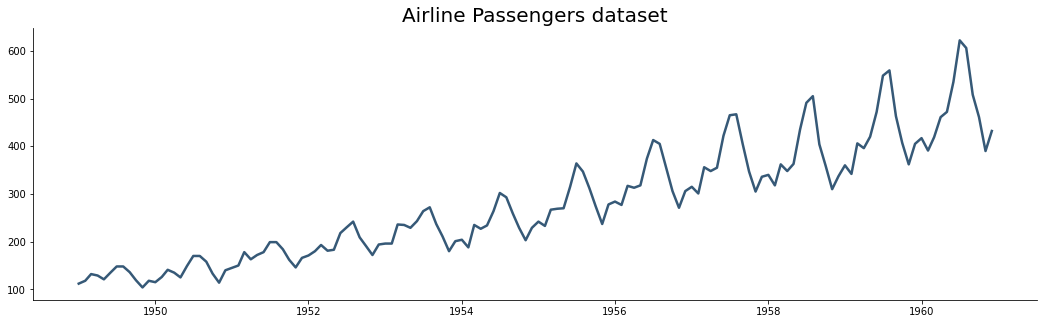

In [ ]:
'''
https://towardsdatascience.com/time-series-from-scratch-stationarity-tests-and-automation-14b02fa5ca4d
'''
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5


# Load
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

# Visualize
plt.title('Airline Passengers dataset', size=20)
plt.plot(df);

In [ ]:
# ADF stationarity test
# Returns: {Test statistic, P-value, Num lags used, {Critical values}, Estmation of maximized information criteria}
adfuller(df['Passengers'])

(0.8153688792060418,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.578770059171598,
  '5%': -2.8840418343195267},
 996.692930839019)

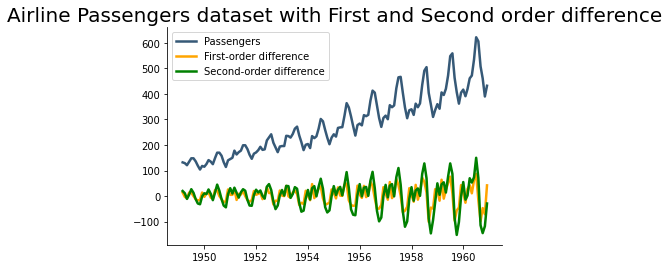

In [ ]:
# First and second order difference
df['Passengers_Diff1'] = df['Passengers'].diff()
df['Passengers_Diff2'] = df['Passengers'].diff(2)

# Don't forget to drop missing values
df = df.dropna()

# Plot
plt.title('Airline Passengers dataset with First and Second order difference', size=20)
plt.plot(df['Passengers'], label='Passengers')
plt.plot(df['Passengers_Diff1'], label='First-order difference', color='orange')
plt.plot(df['Passengers_Diff2'], label='Second-order difference', color='green')
plt.legend();

In [ ]:

# Perform ADF test
adf_diff_1 = adfuller(df['Passengers_Diff1'])
adf_diff_2 = adfuller(df['Passengers_Diff2'])

# Extract P-values
p_1 = adf_diff_1[1]
p_2 = adf_diff_2[1]

# Print
print(f'P-value for 1st order difference: {np.round(p_1, 5)}')
print(f'P-value for 2nd order difference: {np.round(p_2, 5)}')


P-value for 1st order difference: 0.05366
P-value for 2nd order difference: 0.03863


In [ ]:
def make_stationary(data: pd.Series, alpha: float = 0.05, max_diff_order: int = 10) -> dict:
    # Test to see if the time series is already stationary
    if adfuller(data)[1] < alpha:
        return {
            'differencing_order': 0,
            'time_series': np.array(data)
        }
    
    # A list to store P-Values
    p_values = []
    
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        # Perform ADF test
        result = adfuller(data.diff(i).dropna())
        # Append P-value
        p_values.append((i, result[1]))
        
    # Keep only those where P-value is lower than significance level
    significant = [p for p in p_values if p[1] < alpha]
    # Sort by the differencing order
    significant = sorted(significant, key=lambda x: x[0])
    
    # Get the differencing order
    diff_order = significant[0][0]
    
    # Make the time series stationary
    stationary_series = data.diff(diff_order).dropna()
    
    return {
        'differencing_order': diff_order,
        'time_series': np.array(stationary_series)
    }


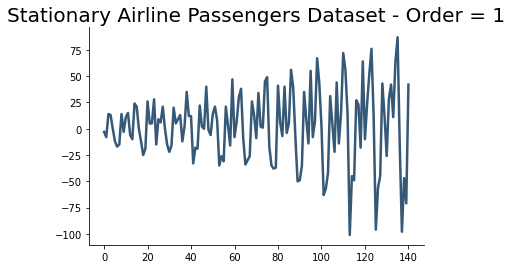

In [ ]:
ap_stationary = make_stationary(
    data=df['Passengers']
)

plt.title(f"Stationary Airline Passengers Dataset - Order = {ap_stationary['differencing_order']}", size=20)
plt.plot(ap_stationary['time_series']);